# fixed chunking

load data

In [1]:
import pandas as pd

file_path = '../data.csv'

try:
    df = pd.read_csv(file_path)
    print(df.head())
except FileNotFoundError:
    print(f"'{file_path}' was not found.")
except Exception as e:
    print(f"error: {e}")

              key                                               text  \
0   389-exception  In addition, as a special exception, Red Hat, ...   
1  3com-microcode  Redistribution and use in source and binary fo...   
2    3dslicer-1.0  3D Slicer Contribution and Software License Ag...   
3      4suite-1.1  License and copyright info for 4Suite software...   
4     996-icu-1.0  "Anti 996" License Version 1.0 (Draft)\n\nPerm...   

           category  
0  Copyleft Limited  
1        Permissive  
2        Permissive  
3        Permissive  
4   Free Restricted  


In [2]:
import pandas as pd
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

# assume df has columns: "key" and "text"

chunks = []

for _, row in df.iterrows():
    key = row["key"]
    text = row["text"]
    
    if not isinstance(text, str) or len(text.strip()) == 0:
        continue  # skip empty
    
    sentences = sent_tokenize(text)  # split into sentences
    for sent in sentences:
        sent = sent.strip()
        if len(sent.split()) >= 3:  # at least 3 words
            chunks.append({"key": key, "chunk": sent})

df_chunks = pd.DataFrame(chunks)
print(df_chunks.head())
print("Total chunks:", len(df_chunks))

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


             key                                              chunk
0  389-exception  In addition, as a special exception, Red Hat, ...
1  389-exception  Non-GPL Code\npermitted under this exception m...
2  389-exception  The files of Non-GPL\nCode may instantiate tem...
3  389-exception  Only Red Hat, Inc. may make changes or additio...
4  389-exception  You must obey the GNU General Public License i...
Total chunks: 88716


In [3]:
df_chunks.to_csv("df_chunks.csv", index=False)

## re: data exploration

In [4]:
df_chunks["chunk_len"] = df_chunks["chunk"].str.split().str.len()

df_chunks["chunk_len"].describe()

count    88716.000000
mean        29.165055
std         24.915765
min          3.000000
25%         14.000000
50%         23.000000
75%         37.000000
max       1034.000000
Name: chunk_len, dtype: float64

<Axes: >

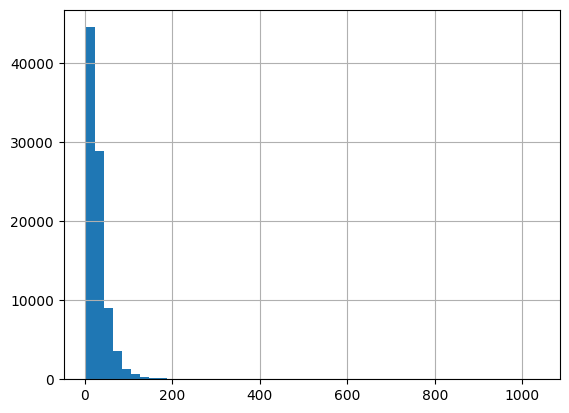

In [5]:
df_chunks["chunk_len"].hist(bins=50)

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df_chunks['chunk'].tolist(), show_progress_bar=True)

df_chunks['embedding'] = embeddings.tolist()

print(f"Embeddings shape: {embeddings.shape}")
print(df_chunks.head())

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001DF10620050>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 6b87016b-5108-4d58-ac71-d6142780043e)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Cau

Embeddings shape: (88716, 384)
             key                                              chunk  \
0  389-exception  In addition, as a special exception, Red Hat, ...   
1  389-exception  Non-GPL Code\npermitted under this exception m...   
2  389-exception  The files of Non-GPL\nCode may instantiate tem...   
3  389-exception  Only Red Hat, Inc. may make changes or additio...   
4  389-exception  You must obey the GNU General Public License i...   

   chunk_len                                          embedding  
0         48  [-0.09315776079893112, -0.04744887724518776, -...  
1         35  [-0.07044431567192078, -0.032603610306978226, ...  
2         32  [-0.1237097829580307, 0.023746024817228317, 0....  
3         15  [-0.04939459636807442, -0.09602229297161102, 0...  
4         34  [-0.04852832853794098, -0.04677494987845421, -...  


In [7]:
from sklearn.model_selection import train_test_split

# Extract embeddings as features
X = embeddings

# Extract target labels from df_chunks
y = df_chunks['key']

# Filter out classes with less than 2 samples to allow stratification
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
mask = y.isin(valid_classes)
X_filtered = X[mask]
y_filtered = y[mask]

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")
print(f"Number of classes: {len(y_train.unique())}")
print(f"Removed {(~mask).sum()} samples from classes with < 2 samples")

Training set size: 70883
Test set size: 17721
Feature dimension: 384
Number of classes: 2482
Removed 112 samples from classes with < 2 samples


In [9]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Evaluate on test set
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

print(f"Training accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

MemoryError: Unable to allocate 1.31 GiB for an array with shape (70883, 2482) and data type float64